In [1]:
import pandas as pd
import numpy as np
import glob
import os, inspect
from IPython.display import Image
import sklearn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
import operator
from zipfile import ZipFile

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

try:
    nltk.download('stopwords')
except ImportError:
    pass

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/Loehr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) + "/seattle"

zf = ZipFile(str(path) + '.zip', 'r')
zf.extractall(path)

filenames = glob.glob(path + "/*.csv")

data = []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    data.append(df)

#reviews = data[0]
listings = data[1]
calendar = data[2]

print("Calendar: " +str(calendar.shape))
print("Listings: " +str(listings.shape))
#print("Reviews: " +str(reviews.shape))


#frame = pd.concat(li, axis=0, ignore_index=True)

Calendar: (1393570, 4)
Listings: (3818, 92)


# Predict the rent based on the features

In [3]:
dataset = pd.merge(listings, calendar, left_on='id', right_on='listing_id', how='left').drop('listing_id', axis=1)
dataset = dataset[::6]
dataset = dataset.dropna(subset=['price_y'])

In [4]:
tags = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 
                'bedrooms', 'bathrooms', 'beds', 'number_of_reviews',
                'host_since', 'room_type', 'extra_people', 'host_identity_verified',
                'guests_included', 'price_y']
tags_x = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 
                'bedrooms', 'bathrooms', 'beds', 'number_of_reviews',
                'host_since', 'room_type', 'extra_people', 'host_identity_verified',
                'guests_included']

for col in tags:    
    idsUnique = len(set(dataset[col])) #get the length of unique set of ID list
    idsTotal = dataset.shape[0] #get the length of complete set of training data
    idsDupli = idsTotal - idsUnique #check if there is a difference between the two length
    print("There are " + str(idsUnique) + " unique " + col + " for " + str(idsTotal) + " total entries")

There are 5 unique host_response_time for 155769 total entries
There are 46 unique host_response_rate for 155769 total entries
There are 3 unique host_acceptance_rate for 155769 total entries
There are 338 unique bedrooms for 155769 total entries
There are 815 unique bathrooms for 155769 total entries
There are 71 unique beds for 155769 total entries
There are 195 unique number_of_reviews for 155769 total entries
There are 1361 unique host_since for 155769 total entries
There are 3 unique room_type for 155769 total entries
There are 45 unique extra_people for 155769 total entries
There are 3 unique host_identity_verified for 155769 total entries
There are 15 unique guests_included for 155769 total entries
There are 554 unique price_y for 155769 total entries


In [5]:
dataset.loc[:, "host_response_time"] = dataset.loc[:, "host_response_time"].fillna(0)
dataset.loc[:, "host_response_rate"] = dataset.loc[:, "host_response_rate"].fillna(0)
dataset.loc[:, "host_acceptance_rate"] = dataset.loc[:, "host_acceptance_rate"].fillna(0)
dataset.loc[:, "bathrooms"] = dataset.loc[:, "bathrooms"].fillna(0)
dataset.loc[:, "bedrooms"] = dataset.loc[:, "bedrooms"].fillna(0)
dataset.loc[:, "beds"] = dataset.loc[:, "beds"].fillna(0)
dataset.loc[:, "number_of_reviews"] = dataset.loc[:, "number_of_reviews"].fillna(0)
dataset.loc[:, "host_since"] = dataset.loc[:, "host_since"].fillna(2018)
dataset.loc[:, "room_type"] = dataset.loc[:, "room_type"].fillna('Private room')
dataset.loc[:, "extra_people"] = dataset.loc[:, "extra_people"].fillna(0)
dataset.loc[:, "host_identity_verified"] = dataset.loc[:, "host_identity_verified"].fillna('f')
dataset.loc[:, "guests_included"] = dataset.loc[:, "guests_included"].fillna(0)

dataset['host_response_rate'] = [rate.replace('%', '') for rate in dataset['host_response_rate'].astype(str)]
dataset['bedrooms'] = dataset['bedrooms'].astype('int32')
dataset['bathrooms'] = dataset['bathrooms'].astype('int32')
dataset['beds'] = dataset['beds'].astype('int32')
dataset['host_since'] = [host[:4] for host in dataset['host_since'].astype(str)]
dataset['extra_people'] = [extra[:-3].replace('$', '') for extra in dataset['extra_people'].astype(str)]
dataset['price_y'] = [price[:-3].replace('$', '').replace(',', '') for price in dataset['price_y'].astype(str)]

In [6]:
dataset = dataset.replace({"host_response_time" : {np.isnan : 0, 'a few days or more' : 1, 'within a day' : 2, 
                                                   'within a few hours' : 3, 'within an hour': 4},
                          "host_acceptance_rate" : {'0%': 0, '100%': 1},
                           "room_type" : {'Entire home/apt': 3, 'Private room': 2, 'Shared room' : 1},
                           "host_identity_verified" : {"f" : 0, "t" : 1}
                          })

In [7]:
y = dataset['price_y']
dataset = dataset.drop('price_y', 1)

X_train, X_test, y_train, y_test = train_test_split(dataset[tags_x].astype(int), y, test_size=0.33, random_state=42)

print("X Train: " + str(X_train.shape))
print("y Train: " + str(y_train.shape))
print("X Test: " + str(X_test.shape))
print("y Train: " + str(y_test.shape))

X Train: (104365, 12)
y Train: (104365,)
X Test: (51404, 12)
y Train: (51404,)


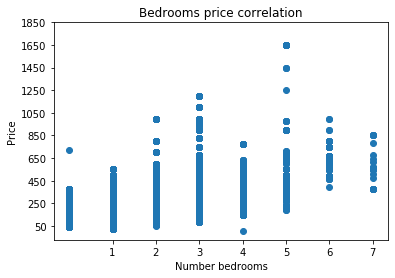

In [8]:
sorted_x = pd.DataFrame([X_train['bedrooms'], y_train]).T.astype(int)
sorted_x = sorted_x.sort_values(by=['price_y'])

plt.scatter(sorted_x.bedrooms, sorted_x.price_y)
plt.title("Bedrooms price correlation")
plt.xlabel("Number bedrooms")
plt.ylabel("Price")
plt.yticks(np.arange(50, 2000, 200))
plt.xticks(np.arange(1, len(set(sorted_x.bedrooms))))
plt.show()

In [9]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print("Mean absolute Error : {:9.2f}".format(round(mae, 2)))
print("Mean squared Error  : {:9.2f}".format(round(mse, 2)))

Mean absolute Error :     44.28
Mean squared Error  :   5022.98


## Vibe of the Neighbourhood

In [10]:
data = dict()
stemmer = SnowballStemmer("english")

for nh, overview in zip(listings['neighbourhood'].dropna().astype(str), listings['neighborhood_overview'].astype(str)):
    if(nh in data):
        data[nh] += overview
    else:
        data[nh] = overview

nb_vibe = {}
nb_freq = {} 
 
for nh in data:
    t = RegexpTokenizer(r'\w+')
    tokens = t.tokenize(data[nh])
    
    stop_words = set(stopwords.words('english'))
    stop_words2 = [*nh.lower().split(' '), 'seattle', 'neighborhood']
    
    tokens = [w.lower() for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if not w in stop_words2]
    tokens = [stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in tokens]
    
    frequency_dist = nltk.FreqDist(tokens)
    nb_freq[nh] = frequency_dist
    nb_vibe[nh] = sorted(frequency_dist, key=frequency_dist.__getitem__, reverse=True)[0:50]

In [11]:
max_words = {}
for nh in nb_vibe:
    max_words[nh] = len(data[nh])
    
top_reviewed_citys = sorted(max_words, key=max_words.get)[::-1][:6]
print(top_reviewed_citys)

['Capitol Hill', 'Ballard', 'Queen Anne', 'Belltown', 'Minor', 'Wallingford']


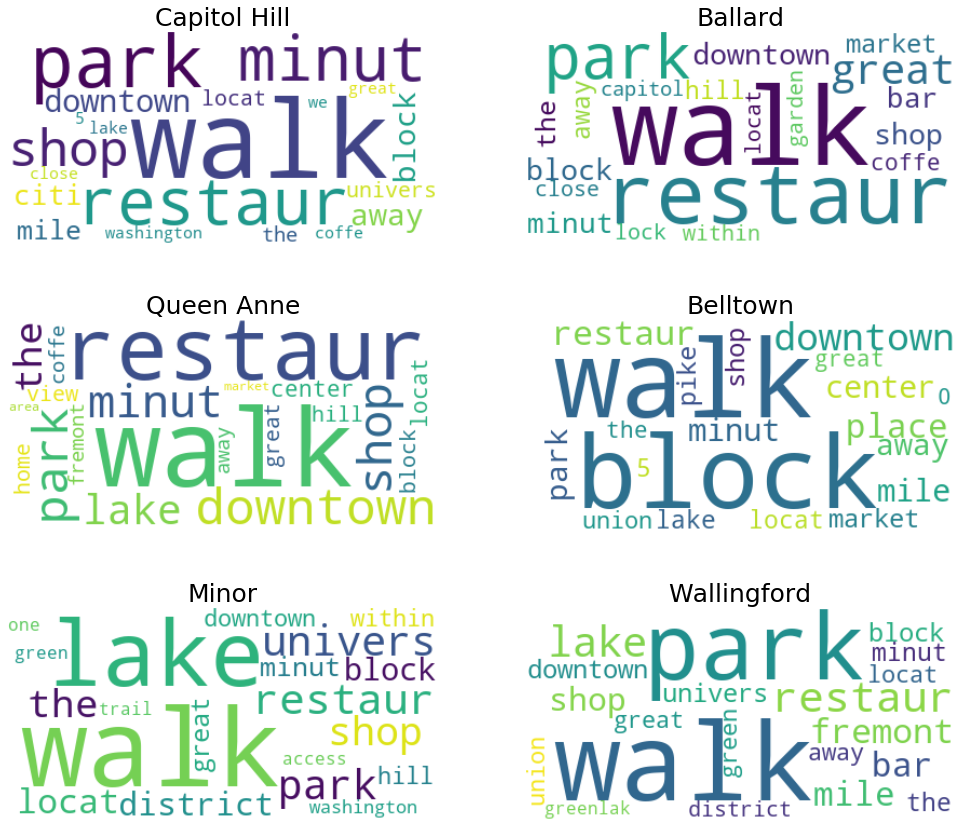

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(17,15))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax, city in zip(axs, top_reviewed_citys):
    wordcloud = WordCloud(max_font_size=100, 
                          max_words=20, background_color="white").generate_from_frequencies(nb_freq[city])
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(city, fontsize=25)

In [13]:
nb = listings[['review_scores_value', 'neighbourhood']].dropna()
X = np.array(nb['neighbourhood'])
y = np.array(nb['review_scores_value'].astype(int))

print(X.shape)
print(y.shape)
print("Neighbourhoods: " + str(len(set(X))))

(2858,)
(2858,)
Neighbourhoods: 79


In [14]:
rating = dict()

for r, nb in zip(y, X):
    if(nb not in rating):
        rating[nb] = [r, 1]
    else:
        rating[nb][0] += r
        rating[nb][1] += 1

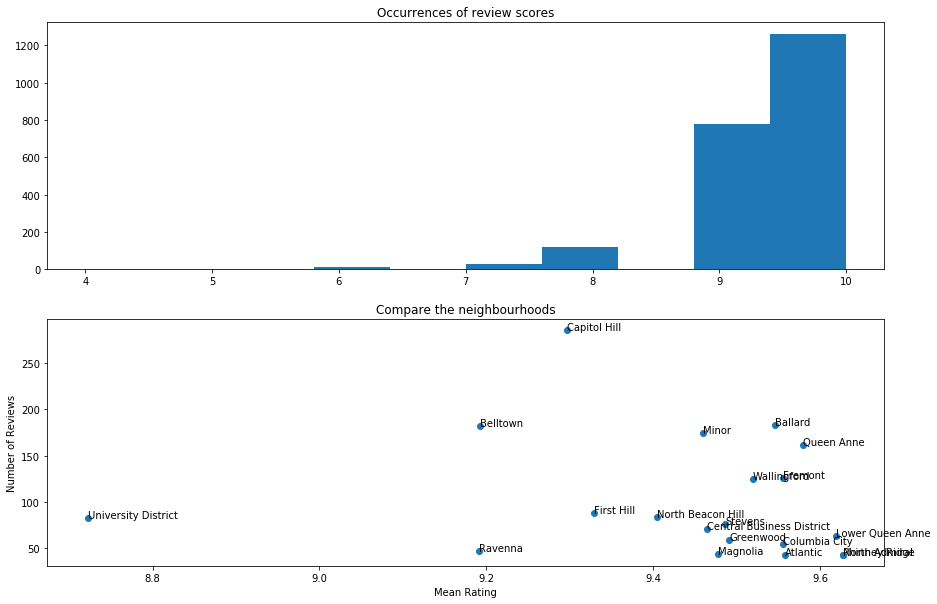

In [15]:
nb = listings[['neighborhood_overview', 'review_scores_value', 'neighbourhood']].dropna()
text = np.array(nb['neighborhood_overview'])
label = nb['review_scores_value'].astype(int)

x = sorted(rating.items(), key=lambda x: x[1])[::-1][:20]
names = [x[0] for x in x]
x_sum = [x[1][0] for x in x]
y_count = [x[1][1] for x in x]
x_mean = []

for x, y in zip(x_sum, y_count):
    x_mean.append(x/y)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
    
ax1.hist(label)
ax1.set_title("Occurrences of review scores")

for i, name in enumerate(names):
    ax2.annotate(name, (x_mean[i], y_count[i]))

ax2.scatter(x_mean, y_count)
ax2.set_title("Compare the neighbourhoods")
ax2.set_ylabel("Number of Reviews")
ax2.set_xlabel("Mean Rating")
plt.show()

# Busiest times of the year

In [16]:
calendar = calendar.dropna()
dates = calendar['date']
price = calendar['price']

year_date = {date: 0 for date in set(dates)}
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
         'October', 'November', 'December']

for date in dates:
    year_date[date] += 1
    
year_num = []

for i, date in enumerate(year_date.items()):
    year_num.append(date[1])

In [17]:
y = np.array(year_num).reshape(-1, 1)
X = np.array(np.arange(1, 366)).reshape(-1, 1)

lr = linear_model.LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

print("Y = " + str(round(lr.coef_[0][0], 2)) + "X + "+ str(round(lr.intercept_[0], 2)))

Y = -0.1X + 2578.35


## Linear Regression
## Y = 0.1X + 2541.56

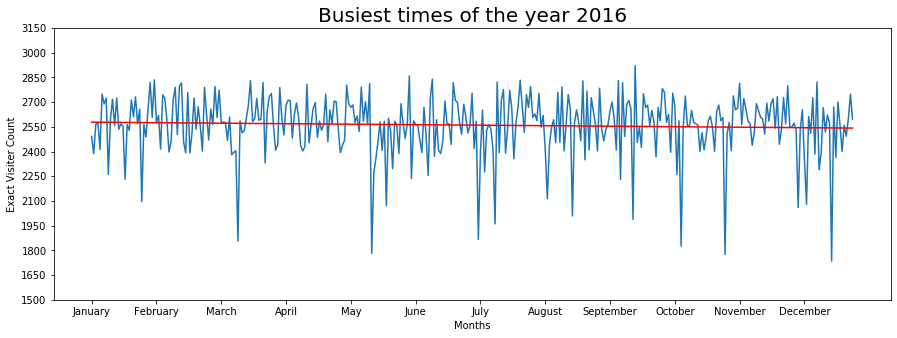

In [18]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(year_num) + 1), year_num)
plt.plot(X, y_pred, color="red")
plt.title("Busiest times of the year 2016", fontsize=20)
plt.xlabel("Months")
plt.ylabel("Exact Visiter Count")
plt.yticks(np.arange(1500, 3250, 150))
plt.xticks(np.arange(1, 365, 31), months)
plt.show()